In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, rankdata

import sys
sys.path.append('../')
from src import data

from netneurotools import metrics 

import mne
from scipy import io 

%matplotlib widget

!date -I

2024-02-13


In [3]:
# stim_weights.npy

## Settings

In [4]:
FC_AVAILABLE = False
datasets_parcellations = {"enigma":["DKT"],"domhof":["DKT","Destrieux","Schaefer"],"rosen_halgren":["MNI-HCP-MMP1"]}

# set
PLOT=True
DATASET = "domhof"
PARCELLATION = "Schaefer"
AMPLITUDE_MASK_SAME_AS_PROBABILITY_MASK = False


if DATASET not in datasets_parcellations.keys():
    print("Invalid dataset selection!")
elif PARCELLATION not in datasets_parcellations[DATASET]:
    print(f"Selected dataset {DATASET} not provided in {PARCELLATION} parcellation!")
    PARCELLATION == datasets_parcellations[DATASET][0]
    print(f"Parcellation set to {PARCELLATION}")
else: 
    print(f"Selected dataset {DATASET} and parcellation {PARCELLATION}.")

Selected dataset domhof and parcellation Schaefer.


## Load data

### Load pytepfit data

In [5]:
empirical = np.load('../data/external/pytepfit/source_estimates/empirical.npz')
empirical['ts'].shape

(400, 200)

In [6]:
empirical['labels'].shape

(200,)

In [7]:
empirical['labels'][:10]

array(['7Networks_LH_Cont_Cing_1-lh', '7Networks_LH_Cont_Cing_2-lh',
       '7Networks_LH_Cont_PFCl_1-lh', '7Networks_LH_Cont_PFCl_2-lh',
       '7Networks_LH_Cont_PFCl_3-lh', '7Networks_LH_Cont_PFCl_4-lh',
       '7Networks_LH_Cont_PFCl_5-lh', '7Networks_LH_Cont_PFCl_6-lh',
       '7Networks_LH_Cont_Par_1-lh', '7Networks_LH_Cont_Par_2-lh'],
      dtype='<U40')

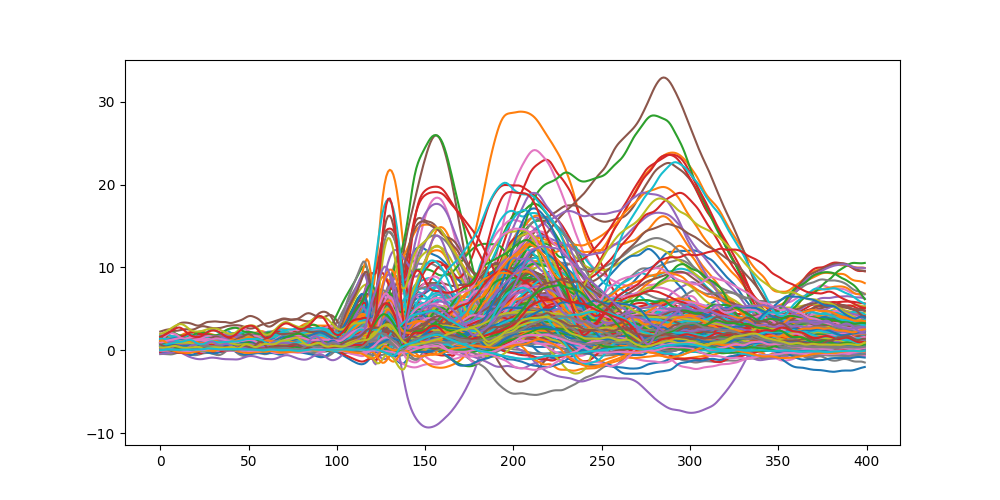

In [8]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.figure()
plt.plot(empirical['ts']);
plt.show()

In [31]:
corrected = mne.baseline.rescale(empirical['ts'], np.array([i for i in range(400)]), (0,80))
# když tady dám rovnou mode= 'zscore', tak to nikde není > 5
corrected.shape

Applying baseline correction (mode: mean)


(400, 200)

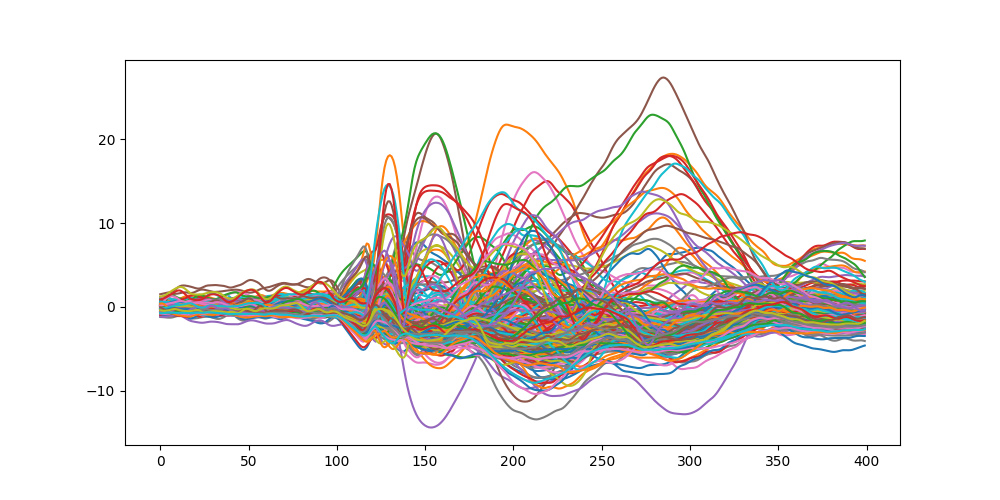

In [34]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.figure()
plt.plot(corrected)
plt.show()

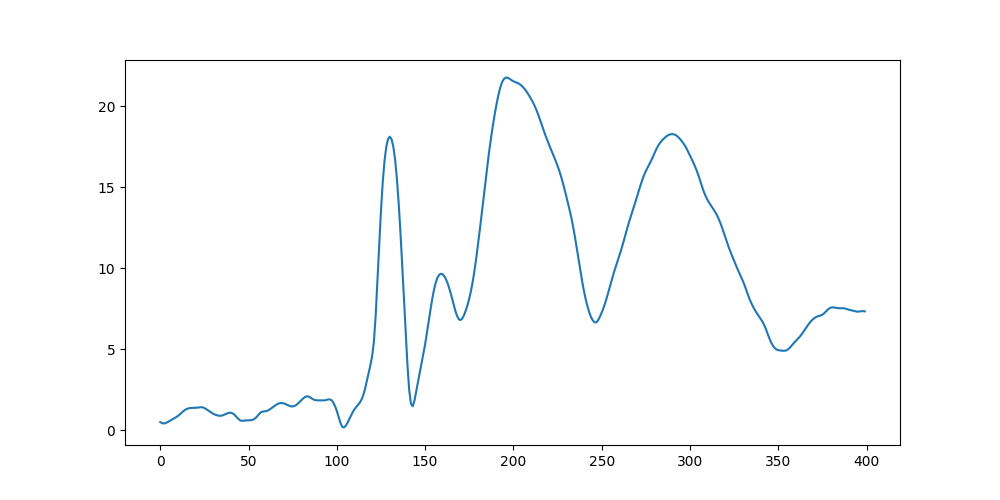

In [33]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.figure()
plt.plot(corrected[:,1])
plt.show()

In [50]:
def get_amplitude_first_peak(seqence, threshold):
    id_above_threshold = None
    for i,val in enumerate(seqence):
        if val > threshold:
            id_above_threshold = i
            break

    if id_above_threshold is None:
        return None

    max_value_above_threshold = seqence[id_above_threshold]
    while seqence[id_above_threshold] > threshold:
        if seqence[id_above_threshold] > max_value_above_threshold:
            max_value_above_threshold = seqence[id_above_threshold]
        id_above_threshold += 1
    
    return max_value_above_threshold


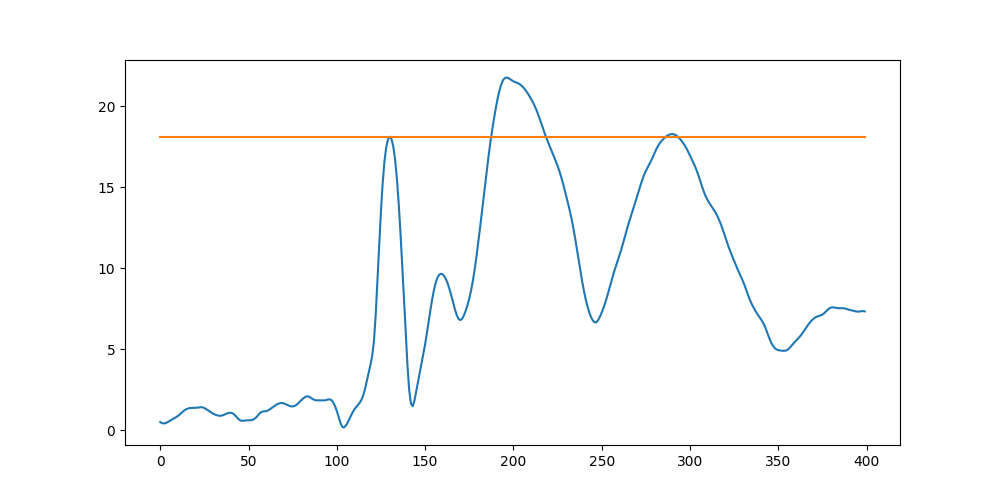

In [53]:
amp = get_amplitude_first_peak(corrected[:,1],10)

plt.rcParams['figure.figsize'] = [10, 5]
plt.figure()
plt.plot(corrected[:,1])
plt.plot([amp]*400)
plt.show()

In [62]:
responses = {} # threshold:response 01
amplitudes = {}

for threshold in range(4,20):
    responses[threshold] = np.any(corrected>threshold,axis=0)
    amplitudes[threshold] = np.array([get_amplitude_first_peak(corrected[:,i],threshold) for i in range(200)],dtype=float)

Text(0.5, 1.0, 'Amplitude (threshold 10)')

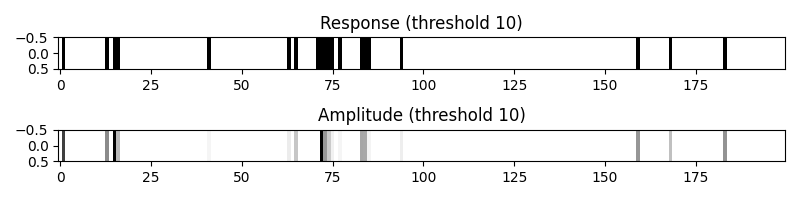

In [66]:
idx = 10

code = np.array(responses[idx])
pixel_per_bar = 4
dpi = 100

fig, axs = plt.subplots(2,1, figsize=(len(code) * pixel_per_bar / dpi, 2), dpi=dpi, tight_layout=True)
axs[0].imshow(code.reshape(1, -1), cmap='binary', aspect='auto',
          interpolation='nearest')
axs[0].set_title(f"Response (threshold {idx})")
axs[1].imshow(amplitudes[10].reshape(1, -1), cmap='binary', aspect='auto',
          interpolation='nearest')
axs[1].set_title(f"Amplitude (threshold {idx})")

22


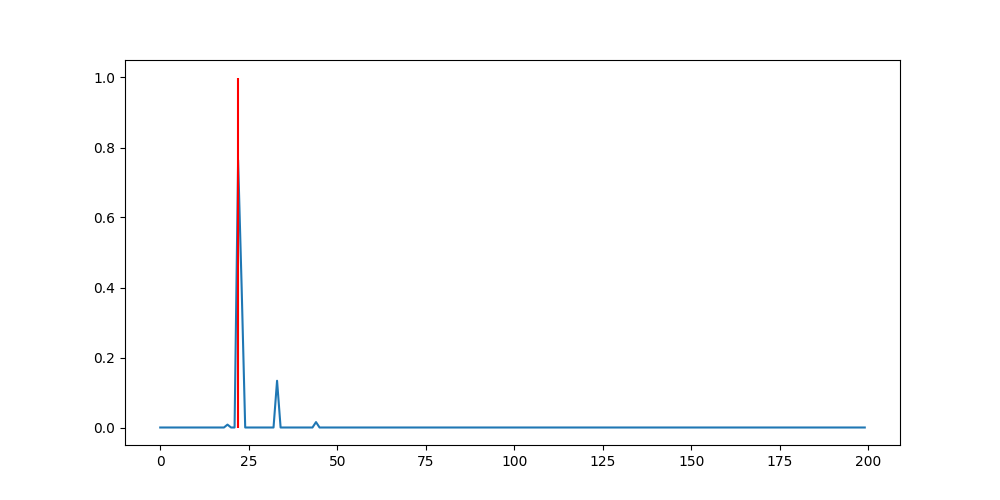

In [76]:
stim_weights = np.load('../data/external/pytepfit/stim_weights.npy')
stim_locatin = np.argmax(stim_weights)
print(stim_locatin)

plt.figure()
plt.plot(stim_weights)
plt.vlines(stim_locatin,0,1,colors='r')
plt.show()

### Load structural (and functional) connectivity data

In [67]:
if DATASET == "enigma":
    SC_W, SC_L, FC = data.load_enigma()

elif DATASET == "domhof":
    SC_W, SC_L, FC = data.load_domhof(PARCELLATION,len(empirical['labels']))

elif DATASET == "rosen_halgren":
    SC_W, SC_L, FC = data.load_rosen_halgren(empirical['labels'])

if FC is not None:
    FC_AVAILABLE = True

print(SC_W.shape)

(200, 200)


Text(0.5, 1.0, 'Structural connectivity - lengths (log)')

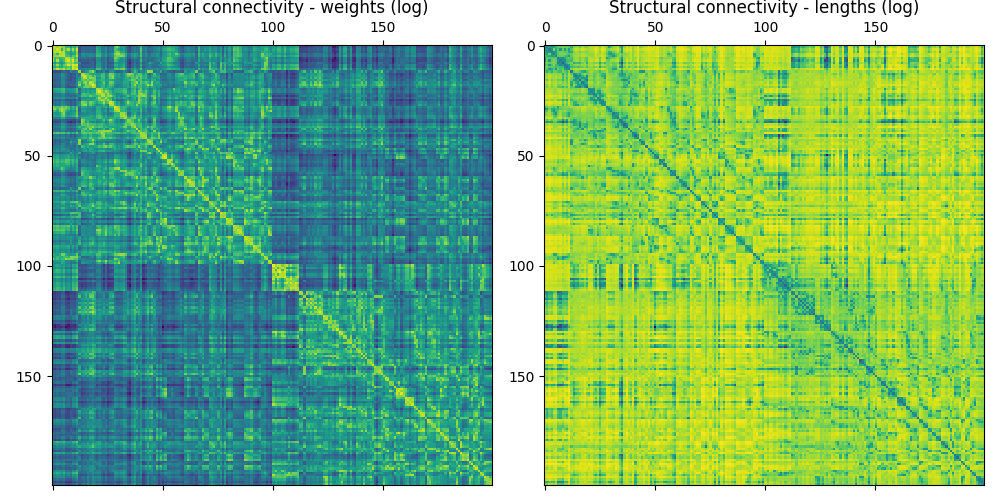

In [68]:
plt.rcParams['figure.figsize'] = [10, 5]

fig, axs = plt.subplots(1, 2, tight_layout=True)
axs[0].matshow(np.log(SC_W))
axs[0].set_title("Structural connectivity - weights (log)")
axs[1].matshow(np.log(SC_L))
axs[1].set_title("Structural connectivity - lengths (log)")

Text(0.5, 1.0, 'ROI distances')

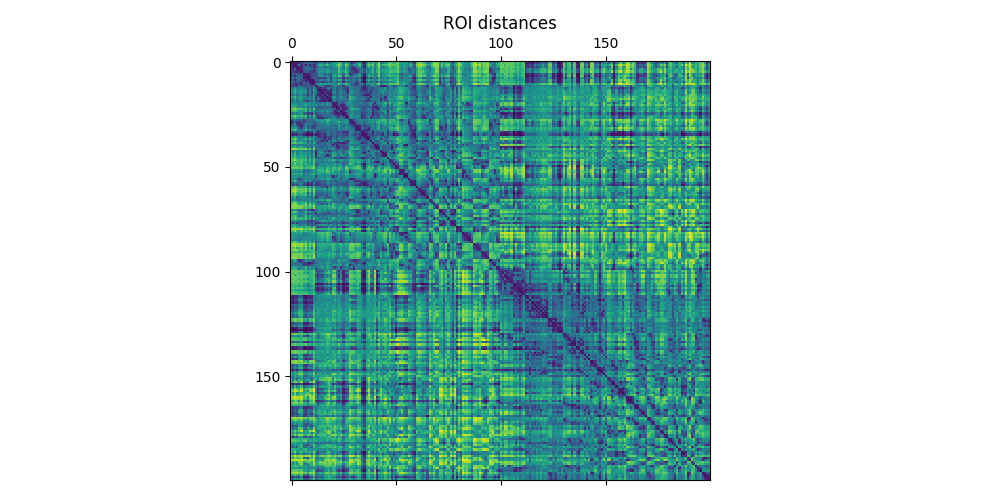

In [69]:
if PARCELLATION == "MNI-HCP-MMP1":
    ED = data.glasser_roi_distances(360,)
else:
    ED = SC_L

fig, axs = plt.subplots(1, 1, tight_layout=True)
axs.matshow(ED)
axs.set_title("ROI distances")

In [70]:
PLOT = False

## Correlations

In [80]:
# shortcut for correlation of X with response probability and amplitude 
def coor_with_response(X):
    for threshold in range(4,20):
        print(f"------------- THRESHOLD {threshold} -------------")
        rpf = responses[threshold]
        raf = amplitudes[threshold]

        r_probability = spearmanr(X[stim_locatin],rpf,nan_policy='omit')
        r_amplitude = spearmanr(X[stim_locatin].flatten(),raf,nan_policy='omit')

        print(f"Correlation with response probabilty: {r_probability.statistic:.3f} (p={r_probability.pvalue:.3f})")
        print(f"Correlation with response amplitude: {r_amplitude.statistic:.3f} (p={r_amplitude.pvalue:.3f})")


In [81]:
coor_with_response(ED)

------------- THRESHOLD 4 -------------
Correlation with response probabilty: -0.098 (p=0.166)
Correlation with response amplitude: 0.017 (p=0.900)
------------- THRESHOLD 5 -------------
Correlation with response probabilty: -0.080 (p=0.260)
Correlation with response amplitude: -0.069 (p=0.649)
------------- THRESHOLD 6 -------------
Correlation with response probabilty: -0.106 (p=0.135)
Correlation with response amplitude: -0.190 (p=0.229)
------------- THRESHOLD 7 -------------
Correlation with response probabilty: -0.162 (p=0.022)
Correlation with response amplitude: 0.023 (p=0.896)
------------- THRESHOLD 8 -------------
Correlation with response probabilty: -0.133 (p=0.060)
Correlation with response amplitude: -0.148 (p=0.434)
------------- THRESHOLD 9 -------------
Correlation with response probabilty: -0.185 (p=0.009)
Correlation with response amplitude: 0.118 (p=0.573)
------------- THRESHOLD 10 -------------
Correlation with response probabilty: -0.151 (p=0.033)
Correlation w

In [82]:
coor_with_response(SC_W) 

------------- THRESHOLD 4 -------------
Correlation with response probabilty: 0.256 (p=0.000)
Correlation with response amplitude: -0.199 (p=0.137)
------------- THRESHOLD 5 -------------
Correlation with response probabilty: 0.168 (p=0.018)
Correlation with response amplitude: -0.082 (p=0.587)
------------- THRESHOLD 6 -------------
Correlation with response probabilty: 0.161 (p=0.023)
Correlation with response amplitude: 0.209 (p=0.185)
------------- THRESHOLD 7 -------------
Correlation with response probabilty: 0.193 (p=0.006)
Correlation with response amplitude: 0.134 (p=0.437)
------------- THRESHOLD 8 -------------
Correlation with response probabilty: 0.204 (p=0.004)
Correlation with response amplitude: 0.119 (p=0.529)
------------- THRESHOLD 9 -------------
Correlation with response probabilty: 0.224 (p=0.001)
Correlation with response amplitude: 0.011 (p=0.959)
------------- THRESHOLD 10 -------------
Correlation with response probabilty: 0.204 (p=0.004)
Correlation with resp

In [83]:
coor_with_response(SC_L) 

------------- THRESHOLD 4 -------------
Correlation with response probabilty: -0.098 (p=0.166)
Correlation with response amplitude: 0.017 (p=0.900)
------------- THRESHOLD 5 -------------
Correlation with response probabilty: -0.080 (p=0.260)
Correlation with response amplitude: -0.069 (p=0.649)
------------- THRESHOLD 6 -------------
Correlation with response probabilty: -0.106 (p=0.135)
Correlation with response amplitude: -0.190 (p=0.229)
------------- THRESHOLD 7 -------------
Correlation with response probabilty: -0.162 (p=0.022)
Correlation with response amplitude: 0.023 (p=0.896)
------------- THRESHOLD 8 -------------
Correlation with response probabilty: -0.133 (p=0.060)
Correlation with response amplitude: -0.148 (p=0.434)
------------- THRESHOLD 9 -------------
Correlation with response probabilty: -0.185 (p=0.009)
Correlation with response amplitude: 0.118 (p=0.573)
------------- THRESHOLD 10 -------------
Correlation with response probabilty: -0.151 (p=0.033)
Correlation w

In [84]:
# shortest path efficiency
shorest_paths,_ = metrics.distance_wei_floyd(SC_L)
shorest_path_eff = np.divide(1,shorest_paths)

if PLOT:
    plt.matshow(shorest_path_eff)

coor_with_response(shorest_path_eff)

------------- THRESHOLD 4 -------------
Correlation with response probabilty: 0.006 (p=0.928)
Correlation with response amplitude: 0.167 (p=0.219)
------------- THRESHOLD 5 -------------
Correlation with response probabilty: 0.056 (p=0.435)
Correlation with response amplitude: 0.007 (p=0.964)
------------- THRESHOLD 6 -------------
Correlation with response probabilty: 0.103 (p=0.145)
Correlation with response amplitude: 0.019 (p=0.905)
------------- THRESHOLD 7 -------------
Correlation with response probabilty: 0.136 (p=0.055)
Correlation with response amplitude: -0.308 (p=0.071)
------------- THRESHOLD 8 -------------
Correlation with response probabilty: 0.069 (p=0.334)
Correlation with response amplitude: -0.201 (p=0.296)
------------- THRESHOLD 9 -------------
Correlation with response probabilty: 0.035 (p=0.626)
Correlation with response amplitude: -0.119 (p=0.579)
------------- THRESHOLD 10 -------------
Correlation with response probabilty: -0.012 (p=0.865)
Correlation with re

/tmp/ipykernel_3278/3541793006.py:3: RuntimeWarning: divide by zero encountered in divide
  shorest_path_eff = np.divide(1,shorest_paths)


In [85]:
com = metrics.communicability_wei(SC_W)
coor_with_response(com)

------------- THRESHOLD 4 -------------
Correlation with response probabilty: 0.253 (p=0.000)
Correlation with response amplitude: -0.243 (p=0.069)
------------- THRESHOLD 5 -------------
Correlation with response probabilty: 0.165 (p=0.020)
Correlation with response amplitude: -0.106 (p=0.485)
------------- THRESHOLD 6 -------------
Correlation with response probabilty: 0.164 (p=0.020)
Correlation with response amplitude: 0.186 (p=0.238)
------------- THRESHOLD 7 -------------
Correlation with response probabilty: 0.196 (p=0.005)
Correlation with response amplitude: 0.109 (p=0.525)
------------- THRESHOLD 8 -------------
Correlation with response probabilty: 0.189 (p=0.007)
Correlation with response amplitude: 0.172 (p=0.365)
------------- THRESHOLD 9 -------------
Correlation with response probabilty: 0.187 (p=0.008)
Correlation with response amplitude: 0.212 (p=0.308)
------------- THRESHOLD 10 -------------
Correlation with response probabilty: 0.221 (p=0.002)
Correlation with resp

In [86]:
SI = metrics.search_information(SC_W,ED) # má tu být ED?

if PLOT:
    plt.matshow(SI)

coor_with_response(SI)

------------- THRESHOLD 4 -------------
Correlation with response probabilty: -0.030 (p=0.674)
Correlation with response amplitude: 0.036 (p=0.793)
------------- THRESHOLD 5 -------------
Correlation with response probabilty: -0.023 (p=0.743)
Correlation with response amplitude: -0.091 (p=0.553)
------------- THRESHOLD 6 -------------
Correlation with response probabilty: -0.055 (p=0.437)
Correlation with response amplitude: -0.160 (p=0.318)
------------- THRESHOLD 7 -------------
Correlation with response probabilty: -0.072 (p=0.313)
Correlation with response amplitude: -0.193 (p=0.266)
------------- THRESHOLD 8 -------------
Correlation with response probabilty: -0.060 (p=0.396)
Correlation with response amplitude: -0.222 (p=0.246)
------------- THRESHOLD 9 -------------
Correlation with response probabilty: -0.111 (p=0.120)
Correlation with response amplitude: -0.120 (p=0.578)
------------- THRESHOLD 10 -------------
Correlation with response probabilty: -0.105 (p=0.141)
Correlation

In [87]:
# https://netneurolab.github.io/netneurotools/_modules/netneurotools/metrics.html#diffusion_efficiency
diffusion = metrics.diffusion_efficiency(SC_W)[1] # tahle funkce určitě má dostat SC, a ne délky L

if PLOT:
    plt.matshow(diffusion)

coor_with_response(diffusion)

------------- THRESHOLD 4 -------------
Correlation with response probabilty: -0.051 (p=0.470)
Correlation with response amplitude: -0.111 (p=0.410)
------------- THRESHOLD 5 -------------
Correlation with response probabilty: -0.054 (p=0.452)
Correlation with response amplitude: -0.248 (p=0.096)
------------- THRESHOLD 6 -------------
Correlation with response probabilty: -0.085 (p=0.229)
Correlation with response amplitude: 0.041 (p=0.798)
------------- THRESHOLD 7 -------------
Correlation with response probabilty: -0.063 (p=0.376)
Correlation with response amplitude: 0.048 (p=0.782)
------------- THRESHOLD 8 -------------
Correlation with response probabilty: -0.028 (p=0.695)
Correlation with response amplitude: -0.159 (p=0.401)
------------- THRESHOLD 9 -------------
Correlation with response probabilty: -0.054 (p=0.447)
Correlation with response amplitude: 0.062 (p=0.770)
------------- THRESHOLD 10 -------------
Correlation with response probabilty: -0.006 (p=0.929)
Correlation w

/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/netneurotools/metrics.py:780: RuntimeWarning: divide by zero encountered in divide
  E_diff = np.divide(1, mfpt)


In [88]:
# tady té funkci možná dávám špatný vstup?
_,_,nav_paths,_,_ = metrics.navigation_wu(SC_L, SC_W)
nav_eff = np.divide(1,nav_paths)

if PLOT:
    plt.matshow(nav_eff)

coor_with_response(nav_eff)

------------- THRESHOLD 4 -------------
Correlation with response probabilty: 0.149 (p=0.036)
Correlation with response amplitude: -0.098 (p=0.473)
------------- THRESHOLD 5 -------------
Correlation with response probabilty: 0.123 (p=0.083)
Correlation with response amplitude: 0.085 (p=0.581)
------------- THRESHOLD 6 -------------
Correlation with response probabilty: 0.114 (p=0.107)
Correlation with response amplitude: 0.032 (p=0.842)
------------- THRESHOLD 7 -------------
Correlation with response probabilty: 0.135 (p=0.057)
Correlation with response amplitude: 0.013 (p=0.942)
------------- THRESHOLD 8 -------------
Correlation with response probabilty: 0.138 (p=0.052)
Correlation with response amplitude: 0.126 (p=0.515)
------------- THRESHOLD 9 -------------
Correlation with response probabilty: 0.211 (p=0.003)
Correlation with response amplitude: -0.141 (p=0.510)
------------- THRESHOLD 10 -------------
Correlation with response probabilty: 0.148 (p=0.037)
Correlation with resp

/tmp/ipykernel_3278/3036424556.py:3: RuntimeWarning: divide by zero encountered in divide
  nav_eff = np.divide(1,nav_paths)
